In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvqregularized import TVqRegularized
from bimpcc.models.tvq_denoising import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from bimpcc.utils import generate_2D_gradient_matrices

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 10

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

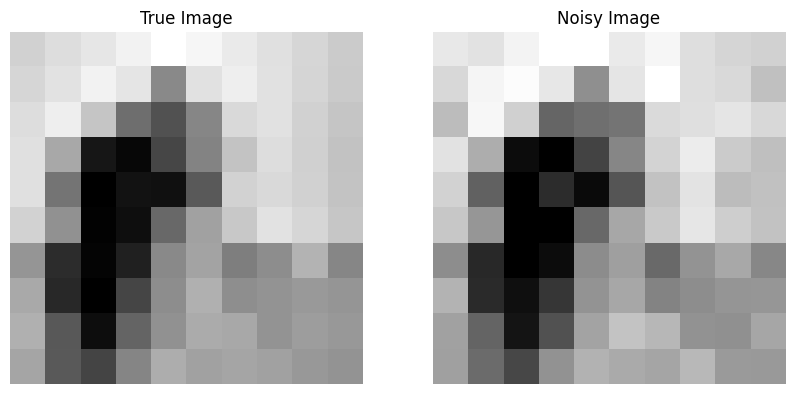

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVqRegularized(true, noisy, epsilon=1e-3, q_param=0.99)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2462
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      281
                     variables with only lower bounds:      101
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      280
Total number of inequality c

/Users/daniela/Documents/REPOSITORIOS GITHUB/bimpcc_2/bimpcc/utils_tvq.py:123: RuntimeWarning: invalid value encountered in power
  - beta * q_param / normKu * (normKu + (q_param - 1) / gamma) ** (q_param - 1),
/Users/daniela/Documents/REPOSITORIOS GITHUB/bimpcc_2/bimpcc/utils_tvq.py:166: RuntimeWarning: invalid value encountered in power
  (1 / (normKu**3)) * (normKu + (q_param - 1) / gamma) ** (q_param - 1)
/Users/daniela/Documents/REPOSITORIOS GITHUB/bimpcc_2/bimpcc/utils_tvq.py:168: RuntimeWarning: invalid value encountered in power
  * (normKu + (q_param - 1) / gamma) ** (q_param - 2)
/Users/daniela/Documents/REPOSITORIOS GITHUB/bimpcc_2/bimpcc/utils_tvq.py:171: RuntimeWarning: invalid value encountered in power
  e = (beta * delta_gamma) / normKu - (beta * q_param / normKu) * (
/Users/daniela/Documents/REPOSITORIOS GITHUB/bimpcc_2/bimpcc/utils_tvq.py:179: RuntimeWarning: invalid value encountered in power
  delta_gamma - q_param * (normKu + (q_param - 1) / gamma) ** (q_param - 1)

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

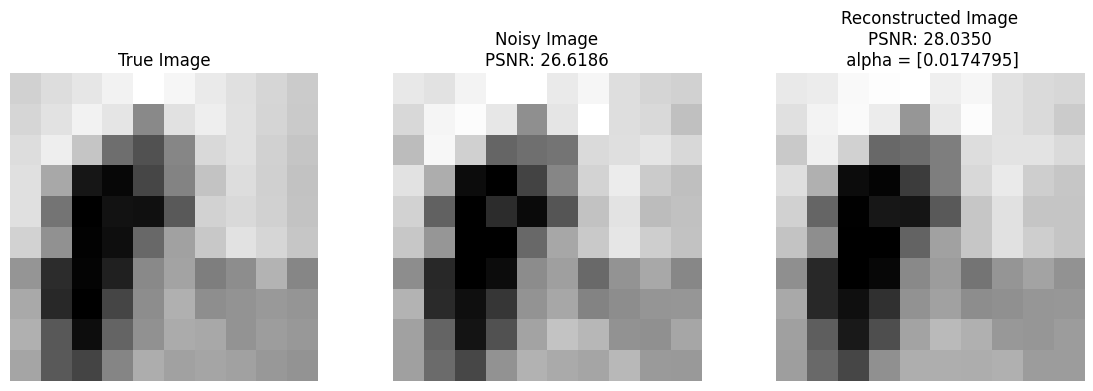

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [11]:
Kx, Ky, K = generate_2D_gradient_matrices(scale)

In [12]:
m = q.flatten().size
n = m // 2

Ku = K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ

In [13]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [14]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
# print(x0_mpcc)

In [15]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3, q_param = 0.99)

In [16]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8608416e-02 9.81e-03 9.62e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

0                 0  0.009801632055593326    2.4882695942399695                 1.0

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.8016321e-03 5.00e-01 1.15e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

1                 0  0.013394947856684962    2.4643390358556325                 0.5

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3394948e-02 2.50e-01 1.10e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

2                 0  0.018018753335486574    2.229635618083725                 0.25

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8018753e-02 1.25e-01 1.03e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

3                 0  0.021529760329733444    1.4593674026215693               0.125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1529760e-02 6.25e-02 1.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

4                 0  0.023944323406013563    0.828084668412486               0.0625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3944323e-02 3.12e-02 9.36e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5                 0  0.028126612970092165    0.496733014411967              0.03125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8126613e-02 1.56e-02 9.25e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

6                 0  0.034815833519531894    0.3102739945155739            0.015625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4815834e-02 1.00e-02 9.51e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

7                 0  0.04400322713451653     0.19268865082752853          0.0078125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4003227e-02 9.96e-03 1.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

8                 0  0.05348236913464163     0.12484634176586265         0.00390625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3482369e-02 9.98e-03 1.02e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

9                 0  0.06119863505934925     0.08842626593698925        0.001953125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1198635e-02 1.00e-02 1.03e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

10                 0  0.06724447348045409     0.06147223709378808       0.0009765625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.7244473e-02 9.99e-03 1.02e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

11                 0  0.07149675470544088     0.04470013851062355      0.00048828125

Overall NLP error.......:   5.1434475289990900e-09    5.1434475289990900e-09


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 22
Number of equality constraint Jacobian evaluations   = 22
Number of inequality constraint Jacobian evaluations = 22
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.365

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with 

12                 0  0.07436147789923803     0.030646607314436334    0.000244140625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4361478e-02 9.80e-03 9.90e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

13                 0  0.07619856471732497     0.018598835972981752    0.0001220703125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6198565e-02 9.90e-03 9.80e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

14                 0  0.07726950846569719     0.011139616461416115    6.103515625e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7269508e-02 9.93e-03 9.76e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

15                 0  0.0778784839098235      0.006629280202585711    3.0517578125e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7878484e-02 9.95e-03 9.73e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

16                 0  0.07821879159309339     0.0037356534060128633   1.52587890625e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.07821879159309339
       x: [ 8.947e-01  9.043e-01 ... -2.414e+00  1.754e-02]
     nit: 22
    info:     status: 0
                   x: [ 8.947e-01  9.043e-01 ... -2.414e+00  1.754e-02]
                   g: [-9.714e-09  2.644e-04 ...  8.977e-16 -1.225e-14]
             obj_val: 0.07821879159309339
              mult_g: [-3.492e-02 -3.704e-08 ...  2.776e-02  3.881e-04]
            mult_x_L: [ 1.118e-11  1.106e-11 ...  0.000e+00  5.701e-10]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 23
    njev: 24

Intermediate fn: 0.07821879159309339

complementarity: 0.0037356534060128638

* (STOPPED) Iteration 18: Solving the NLP problem for t = 1e-05 with complementarity: 0.0037356534060128633

In [17]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

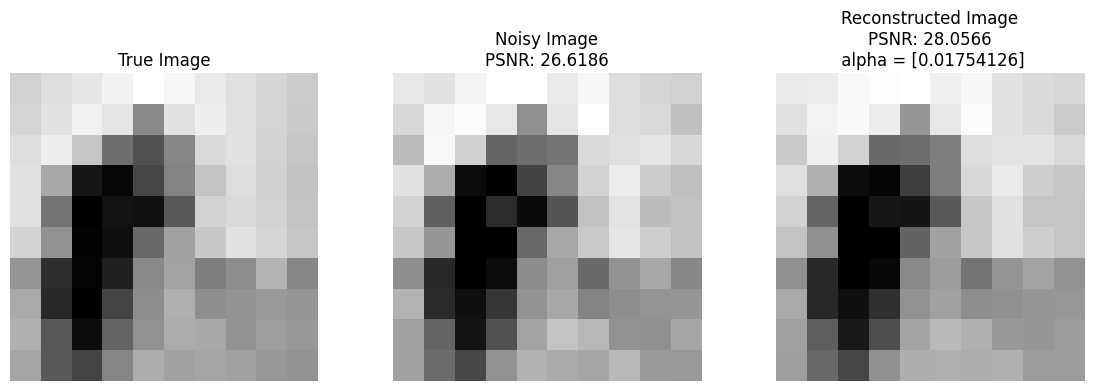

In [18]:
u_mpcc_scaled = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc_scaled,alpha_mpcc)

In [19]:
x0_mpcc1 = np.concatenate((u_mpcc,q_mpcc,r_mpcc,delta_mpcc,theta_mpcc,alpha_mpcc))

In [20]:
mpcc_model1 = TVDenoisingMPCC(true, noisy, x0=x0_mpcc1, epsilon=1e-3, q_param = 0.95)

In [21]:
res_mpcc1,x_opt_mpcc1,fun_opt_mpcc1 = mpcc_model1.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2678
Number of nonzeros in inequality constraint Jacobian.:      450
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      551
                     variables with only lower bounds:      281
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      460
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8218792e-02 9.96e-03 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

KeyboardInterrupt: 

In [ ]:
u_mpcc1, q_mpcc1, r_mpcc1, delta_mpcc1, theta_mpcc1, alpha_mpcc1 = mpcc_model1.objective_func.parse_vars(x_opt_mpcc1)

In [ ]:
u_mpcc1 = u_mpcc1.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc1,alpha_mpcc1)